<a href="https://colab.research.google.com/github/msalmankhan03/Deep-Learning/blob/main/CNN/Chest_X_ray_Images_(Pneumonia_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
# Download Chest X-ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:34<00:00, 42.1MB/s]
100% 2.29G/2.29G [00:34<00:00, 70.6MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip -d chest_xray


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [4]:
!pip install tensorflow opencv-python matplotlib scikit-learn
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


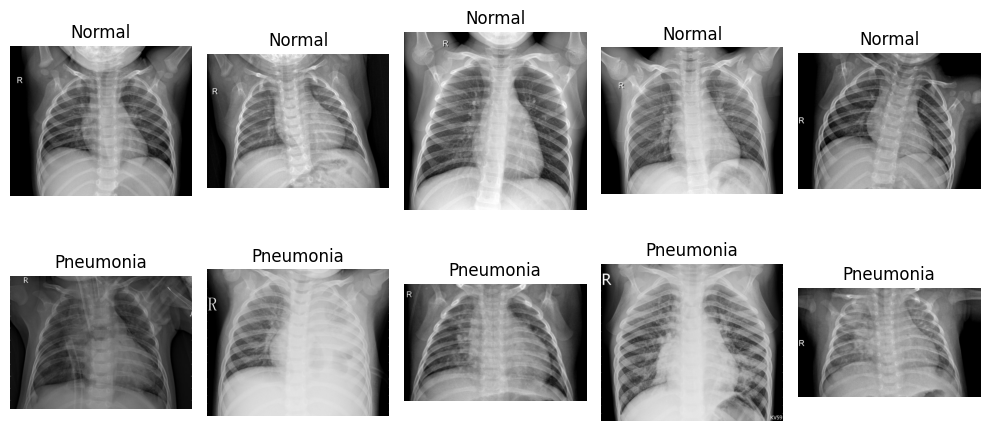

In [5]:
# Path setup
train_dir = '/content/chest_xray/chest_xray/chest_xray/train'
normal_dir = os.path.join(train_dir, 'NORMAL')
pneu_dir   = os.path.join(train_dir, 'PNEUMONIA')

# Visualize a few images
plt.figure(figsize=(10,5))
for i, fname in enumerate(os.listdir(normal_dir)[:5]):
    img = cv2.imread(os.path.join(normal_dir,fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title('Normal')
    plt.axis('off')

for i, fname in enumerate(os.listdir(pneu_dir)[:5]):
    img = cv2.imread(os.path.join(pneu_dir,fname))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
input_shape = (224,224,3)
inputs = Input(shape=input_shape)
base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs, outputs)
# Freeze base first
for layer in base.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Define image size and batch size
IMG_SIZE = (224, 224)   # ResNet50 input size
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixels to [0,1]
    rotation_range=15,       # Random rotation
    width_shift_range=0.1,   # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,         # Shear
    zoom_range=0.1,          # Zoom
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels
)

# Validation and test data generators (no augmentation, only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
# Paths
train_dir = '/content/chest_xray/chest_xray/chest_xray/train'
val_dir   = '/content/chest_xray/chest_xray/chest_xray/val'
test_dir  = '/content/chest_xray/chest_xray/chest_xray/test'

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification: Normal vs Pneumonia
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
for layer in base.layers[-20:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7276 - loss: 0.5056

163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 661ms/step - accuracy: 0.7282 - loss: 0.5047 - val_accuracy: 0.5000 - val_loss: 0.7167 - learning_rate: 1.0000e-05
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.9115 - loss: 0.2252 - val_accuracy: 0.5000 - val_loss: 0.6808 - learning_rate: 1.0000e-05
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.9213 - loss: 0.1968 - val_accuracy: 0.5000 - val_loss: 2.3205 - learning_rate: 1.0000e-05
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9348 - loss: 0.1726

163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9348 - loss: 0.1726 - val_accuracy: 0.5625 - val_loss: 1.6106 - learning_rate: 1.0000e-05
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9367 - loss: 0.1631 - val_accuracy: 0.5000 - val_loss: 2.1378 - learning_rate: 1.0000e-05
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9438 - loss: 0.1461

163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9438 - loss: 0.1461 - val_accuracy: 0.8125 - val_loss: 0.6240 - learning_rate: 1.0000e-05
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.9368 - loss: 0.1621 - val_accuracy: 0.6875 - val_loss: 0.6583 - learning_rate: 1.0000e-05
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.9430 - loss: 0.1365 - val_accuracy: 0.8125 - val_loss: 0.4892 - learning_rate: 1.0000e-05
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 598ms/step - accuracy: 0.9317 - loss: 0.1535 - val_accuracy: 0.5625 - val_loss: 1.0478 - learning_rate: 1.0000e-05
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.9467 - loss: 0.1343 - val_accuracy: 0.6250 - val_loss: 0.6505 - learning_rate: 1.0000e-05
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 592ms/step - accuracy: 0.9484 - loss: 0.1323 - val_accuracy: 0.6250 - val_loss: 1.1989 - learning_rate: 1.0000e-05
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step 

163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.9413 - loss: 0.1446 - val_accuracy: 0.8750 - val_loss: 0.3948 - learning_rate: 1.0000e-05
Epoch 13/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9521 - loss: 0.1320 - val_accuracy: 0.8125 - val_loss: 0.4836 - learning_rate: 1.0000e-05
Epoch 14/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.9568 - loss: 0.1224 - val_accuracy: 0.5000 - val_loss: 2.6633 - learning_rate: 1.0000e-05
Epoch 15/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9420 - loss: 0.1433 - val_accuracy: 0.5625 - val_loss: 1.9003 - learning_rate: 1.0000e-05
Epoch 16/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 602ms/step - accuracy: 0.9474 - loss: 0.1324 - val_accuracy: 0.5625 - val_loss: 2.1139 - learning_rate: 1.0000e-05
Epoch 17/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.9538 - loss: 0.1299 - val_accuracy: 0.5625 - val_loss: 1.2436 - learning_rate: 1.0000e-05
Epoch 18/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/s

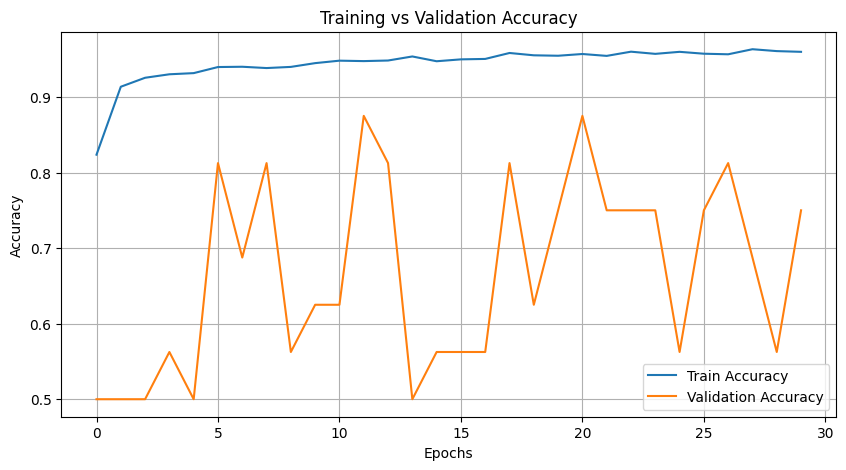

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
model = load_model('best_model.h5')
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
auc = roc_auc_score(y_true, y_pred_prob)
print("AUC:", auc)
cm = confusion_matrix(y_true, y_pred)


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step
              precision    recall  f1-score   support

      Normal       0.85      0.83      0.84       234
   Pneumonia       0.90      0.91      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

AUC: 0.9444006136313828


In [2]:
def predict_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224))
    img_norm = img_resized/255.0
    img_input = np.expand_dims(img_norm, axis=0)
    prob = model.predict(img_input)[0][0]
    label = 'Pneumonia' if prob>0.5 else 'Normal'
    print(f"Predicted: {label} (prob={prob:.2f})")
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()


In [3]:
import os
import random

# Define path to NORMAL images
normal_dir = 'chest_xray/chest_xray/train/NORMAL'

# Pick a random image file
random_image = random.choice(os.listdir(normal_dir))

# Full path
image_path = os.path.join(normal_dir, random_image)

print("Sample image path:", image_path)


FileNotFoundError: [Errno 2] No such file or directory: 'chest_xray/chest_xray/train/NORMAL'

In [1]:
predict_image(image_path,model)

NameError: name 'predict_image' is not defined